# CartoBlobPy Demo
This notebook shows how to load a map from the assets and check whether a straight line between two world points collides with obstacles using `Graph.is_free_path`.

In [1]:
# Setup: add repo root to Python path and import package
import sys, os
sys.path.append("../src")
from cartoblobpy.graph import Graph
from cartoblobpy.assets import get_map_path, list_example_maps

Available maps: ['map002.yaml', 'map004.yaml', 'map005.yaml', 'map006.yaml', 'map007.yaml', 'map008.yaml', 'map009.yaml', 'map010.yaml', 'map011.yaml', 'map012.yaml', 'map013.yaml', 'map014.yaml', 'map015.yaml']
Using map: C:\Users\emirc\OneDrive - NTNU\Projects\image_to_map\cartoblobpy\src\cartoblobpy\assets\map002.yaml


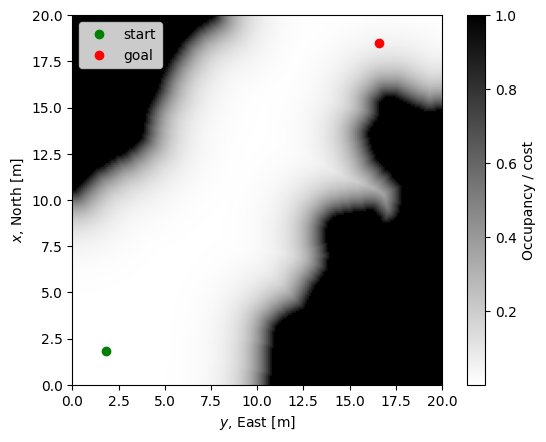

In [2]:
# Load a sample map from assets
available = list_example_maps()
print("Available maps:", available)
map_name = available[0] if available else 'map005.yaml'
yaml_path = get_map_path(map_name)
print("Using map:", yaml_path)

g = Graph()
g.coordinate_frame = "NED"  # or "ENU"
g.load_from_yaml(yaml_path)
g.inflate_obstacles(radius=1.0, use_world_units=True)  # 5 meters
ax = g.plot(cmap="gray_r")

Random world point: [12.   7.5]
Distance to shore (radius): 3.511409973215888 meters


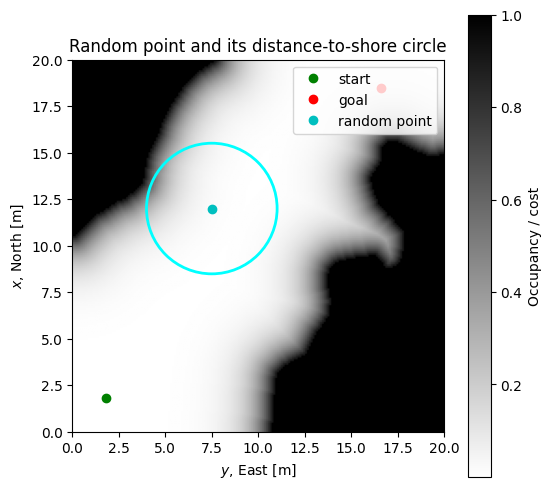

In [ ]:
# Random point + circle (distance to shore)
import numpy as np
import matplotlib.pyplot as plt

W, H = g.width, g.height
x = 12.0
y = 7.5
rand_point_world = np.array([x, y])
print("Random world point:", rand_point_world)

radius_m = g.distance_to_closest_obstacle(rand_point_world)
print("Distance to shore (radius):", radius_m, "meters")

fig, ax = plt.subplots(figsize=(6, 6))
g.plot(ax=ax, cmap="gray_r", show_colorbar=True)

if g.coordinate_frame == "ENU":
    x_plot, y_plot = rand_point_world[0], rand_point_world[1]
else:  # NED world = [x_north, y_east] -> EN plotting plane = [x_east, y_north]
    x_plot, y_plot = rand_point_world[1], rand_point_world[0]

ax.plot(x_plot, y_plot, 'co', markersize=6, label='random point')

# Draw circle with radius equal to distance to shore (in meters)
circle = plt.Circle((x_plot, y_plot), radius_m, color='cyan', fill=False, linewidth=2)
ax.add_patch(circle)
ax.set_title("Random point and its distance-to-shore circle")
ax.legend(loc='upper right')
plt.show()

Point 1: [16.1188779   1.58818673]
Point 2: [ 8.6575092  15.06435334]
p1_is_free: False
p2_is_free: False
is_free_path: False


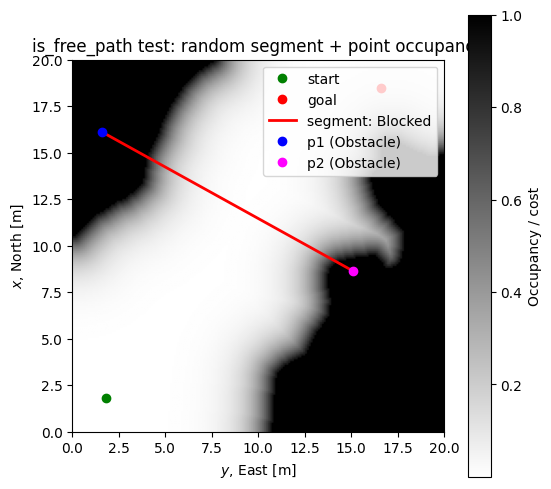

In [ ]:
# Random segment collision test using is_free_path
import numpy as np
import matplotlib.pyplot as plt

# Ensure graph `g` exists
assert 'g' in globals(), "Graph 'g' must be created above. Run previous cells."

# Helper: check if a world point lies in free space
def point_is_free(world_point):
    pg = g.world_to_grid(world_point).astype(int)
    # bounds check
    r, c = pg[0], pg[1]
    if r < 0 or c < 0 or r >= g.grid.shape[0] or c >= g.grid.shape[1]:
        return False
    return g.grid[r, c] <= g.occupancy_threshold

# Pick two random world points within map extents
W, H = g.width, g.height
rng = np.random.default_rng()
p1 = np.array([rng.uniform(0, W), rng.uniform(0, H)])
p2 = np.array([rng.uniform(0, W), rng.uniform(0, H)])
print("Point 1:", p1)
print("Point 2:", p2)

# Check if individual points are free
p1_free = point_is_free(p1)
p2_free = point_is_free(p2)
print("p1_is_free:", p1_free)
print("p2_is_free:", p2_free)

# Check collision-free straight path
free = g.is_free_path(p1, p2)
print("is_free_path:", free)

# Plot occupancy grid and the segment
fig, ax = plt.subplots(figsize=(6, 6))
g.plot(ax=ax, cmap="gray_r", show_colorbar=True)

# Convert points for plotting plane depending on frame
def to_plot_coords(world_point):
    if g.coordinate_frame == "ENU":
        return world_point[0], world_point[1]
    else:
        return world_point[1], world_point[0]

x1, y1 = to_plot_coords(p1)
x2, y2 = to_plot_coords(p2)

# Choose color based on collision status
line_color = "lime" if free else "red"
ax.plot([x1, x2], [y1, y2], color=line_color, linewidth=2, label=f"segment: {'Free' if free else 'Blocked'}")

# Marker styles based on point free status
ax.plot(x1, y1, 'o', color='blue', markersize=6, label=f"p1 ({'Free' if p1_free else 'Obstacle'})")
ax.plot(x2, y2, 'o', color='magenta', markersize=6, label=f"p2 ({'Free' if p2_free else 'Obstacle'})")

ax.set_title("is_free_path test: random segment + point occupancy")
ax.legend(loc='upper right')
plt.show()